<div style="padding-bottom:30px">
<a href="http://iqtk.io"><img src="https://discover.iqtk.io/assets/logotype_blue_small.png" style="width:100px; margin-left:0px"></img></a>
<p style="color:#9E9E9E">
<a href="http://iqtk.io">Getting Started Guide</a> // <a href="https://goo.gl/forms/2cOmuUrQ3n3CKpim1">Documentation Feedback</a></p>
</div>

<h1 style="color:#9E9E9E">Gene expression analysis</h1>

In this analysis we perform differential expression analysis with the Cufflinks toolset which includes [cufflinks](https://cole-trapnell-lab.github.io/cufflinks/), [tophat](https://ccb.jhu.edu/software/tophat/), and [bowtie2](http://bowtie-bio.sourceforge.net/bowtie2/index.shtml). You can brush up on gene expression profiling [here](https://en.wikipedia.org/wiki/Gene_expression_profiling).

There is some background reading so once you've completed the [getting started documentation]() you'll be ready for this tutorial!

<h2 style="color:#9E9E9E">Required Data and Parameterization</h2>

The starting point for this workflow is the following:

<ul style="font-size:15px">
<ol><b>1. Reference FASTA:</b> GCS path to reference genome assembly in FASTA format (aginst which to align reads).</ol>
<ol><b>2. Genes GTF:</b> GCS path to file listing input reads.</ol>
<ol><b>3. Condition A pairs:</b> A comma-separated list of read pairs belonging to condition A.</ol>
<ol><b>2. Condition B pairs:</b> A comma-separated list of read pairs belonging to condition B.</ol>
</ul>


Each of these should be present on Google Cloud Storage. A cloud storage containing FASTQ base calls for a transcriptome sequencing run on the MiSeq sequencer is shown below.

<img src="https://discover.iqtk.io/assets/miseq-sync-1.png" style="padding:20px; height:400px"></img>

The screenshot above is of data synced to cloud storage using the `iqtk uplink` utility for sending instrument data to cloud storage as it is generated. [Read more](https://github.com/iqtk/iqtk) about deploying the `uplink` utility at your site. Next we discuss two of the following three ways workflows can be triggered.

<ul style="font-size:15px">
<ol>1. From the DataFlow UI</ol>
<ol>2. Using the `iqtk` command-line tool</ol>
<ol>3. [Programmatically](https://github.com/iqtk/iqtk/tree/master/inquiry/functions/storage-trigger) in response to an instrument data sync event.</ol>

</ul>

<h3 style="color:#9E9E9E">Parameterization from the DataFlow UI</h2>

The easiest way to initiate a workflow is from the DataFlow template job submission UI. For this workflow the submission dialog will look as follows and simply requires you provide the GCS paths to the necessary input files.

<img src="https://discover.iqtk.io/assets/submit-sshot-rna-quantification.png" style="padding:20px; height:600px"></img>

<h3 style="color:#9E9E9E">Parameterization from the command-line</h2>

Initiating workflow runs from the command line requires that the `iqtk` utility is installed on your system (such as via `pip install iqtk`) and that you have authenticated with GCP to access the APIs and file objects referenced by and required for your run. Provided these, a workflow can be initiated using the following command provided a JSON config file like the one following that.

In [ ]:
%%bash
iqtk run transcriptomics --config=path_to_your_config.json

```json
{
  "ref_fasta": "gs://cflow-public/data/genomes/Drosophila_melanogaster/Ensembl/BDGP5.25/Sequence/BowtieIndex/genome.fa",
  "genes_gtf": "gs://cflow-public/data/genomes/Drosophila_melanogaster/Ensembl/BDGP5.25/Annotation/Archives/archive-2015-07-17-14-30-26/Genes/genes.gtf",
  "cond_a_pairs": [
      ["gs://cflow-public/data/rnaseq/downsampled_reads/GSM794483_C1_R1_1_small.fq",
       "gs://cflow-public/data/rnaseq/downsampled_reads/GSM794483_C1_R1_2_small.fq"],
      ["gs://cflow-public/data/rnaseq/downsampled_reads/GSM794484_C1_R2_1_small.fq",
       "gs://cflow-public/data/rnaseq/downsampled_reads/GSM794484_C1_R2_2_small.fq"],
      ["gs://cflow-public/data/rnaseq/downsampled_reads/GSM794485_C1_R3_1_small.fq",
       "gs://cflow-public/data/rnaseq/downsampled_reads/GSM794485_C1_R3_2_small.fq"]
      ],
  "cond_b_pairs": [
       ["gs://cflow-public/data/rnaseq/downsampled_reads/GSM794486_C2_R1_1_small.fq",
        "gs://cflow-public/data/rnaseq/downsampled_reads/GSM794486_C2_R1_2_small.fq"],
       ["gs://cflow-public/data/rnaseq/downsampled_reads/GSM794487_C2_R2_1_small.fq",
        "gs://cflow-public/data/rnaseq/downsampled_reads/GSM794487_C2_R2_2_small.fq"],
       ["gs://cflow-public/data/rnaseq/downsampled_reads/GSM794488_C2_R3_1_small.fq",
        "gs://cflow-public/data/rnaseq/downsampled_readsGSM794488_C2_R3_2_small.fq"]
       ]
}
```

Once our job is submitted we'll be able to check its status using the Cloud DataFow UI as described in the [getting started documentation](). For illustration this workflow should look like the following:

<img src="https://discover.iqtk.io/assets/wf-sshot-rna-quantification.png" style="padding:20px; height:700px"></img>

For the interested and for reference we include below the code for this workflow and [refer](https://github.com/iqtk/iqtk/blob/master/inquiry/toolkit/rna_quantification/operations.py) to the code for the set of operations used.

```python
class TranscriptomicsWorkflow(Workflow):
    """Quantify transcript levels using the Tophat/Cufflinks/Cuffdiff pipeline."""

    def __init__(self):
        """Initialize a workflow."""
        self.meta = [omitted for brevity]

        super(TranscriptomicsWorkflow, self).__init__()

    def define(self):
        p, args = self.p, self.args

        # For each condition, create a PCollection to store the input read pairs.
        reads_a = util.fc_create(p, args.cond_a_pairs)
        reads_b = util.fc_create(p, args.cond_b_pairs)

        # For each pair of reads, use tophat to perform split-read alignment.
        # Condition A.
        th_a = (reads_a | task.ContainerTaskRunner(
            ops.TopHat(args=args,
                       ref_fasta=args.ref_fasta,
                       genes_gtf=args.genes_gtf,
                       tag='cond_a')
            ))

        th_b = (reads_b | task.ContainerTaskRunner(
            ops.TopHat(args=args,
                       ref_fasta=args.ref_fasta,
                       genes_gtf=args.genes_gtf,
                       tag='cond_b')
            ))

        # Subset the outputs of the tophat steps to obtain only the bam (alignment)
        # files. Then combine the collections.
        align_a = util.match(th_a, {'file_type': 'bam'})
        align_b = util.match(th_b, {'file_type': 'bam'})
        align = util.combine(p, (align_a, align_b))

        # For each set of reads, perform a transcriptome assembly with cufflinks,
        # yielding one gtf feature annotation for each input read set.
        cl = (align | task.ContainerTaskRunner(
            ops.Cufflinks(args=args)
            ))

        # Perform a single `cuffmerge` operation to merge all of the gene
        # annotations into a single annotation.
        cm = (util.match(cl, {'file_type': 'transcripts.gtf'})
              | task.ContainerTaskRunner(
                  ops.CuffMerge(args=args,
                                ref_fasta=args.ref_fasta,
                                genes_gtf=args.genes_gtf)
                  ))

        # Run a single cuffdiff operation comparing the prevalence of features in
        # the input annotatio across conditions using reads obtained for those
        # conditions.
        cd = (util.match(cm, {'file_type': 'gtf'})
              | task.ContainerTaskRunner(
                  ops.CuffDiff(args=args,
                               ref_fasta=args.ref_fasta,
                               genes_gtf=args.genes_gtf,
                               cond_a_bams=align_a,
                               cond_b_bams=align_b)
                  ))

        return cd

```

<h2 style="color:#9E9E9E">Exploring the data</h2>

When the workflow is complete you can obtain the path in Google Cloud Storage to the resulting files as described in the [getting started documentation](). Workflow runs produce raw data as well as BigQuery database entries. We can explore the latter through the BigQuery UI, provided the project, dataset, and table destination provided in our input. This should look like the following:

<img src="https://discover.iqtk.io/assets/bq-sshot-rna-quantification.png" style="padding:20px; height:400px"></img>

Next we'll pull down a subset of this data from BigQuery into a Pandas data_frame permitting further exploratory and interactive usage.

In [2]:
import google.datalab.bigquery as bq
query = bq.Query('SELECT * FROM `jbei-cloud.somedataset.sometable2` LIMIT 3')
output_options = bq.QueryOutput.table(use_cache=False)
result = query.execute(output_options=output_options).result()
result.to_dataframe()

,id,geneid,gene,locus,sample1,sample2,status,expression1,expression2,lnFoldChange,testStatistic,pValue,qValue,significant
0,XLOC_001687,XLOC_001687,l(2)05714,2L:4969003-4971453,C1,C2,NOTEST,None,None,None,None,1.0,1.0,None
1,XLOC_014024,XLOC_014024,CG14408,X:14721090-14726090,C1,C2,NOTEST,None,None,None,None,1.0,1.0,None
2,XLOC_000602,XLOC_000602,gcm2,2L:9608478-9612710,C1,C2,NOTEST,None,None,None,None,1.0,1.0,None


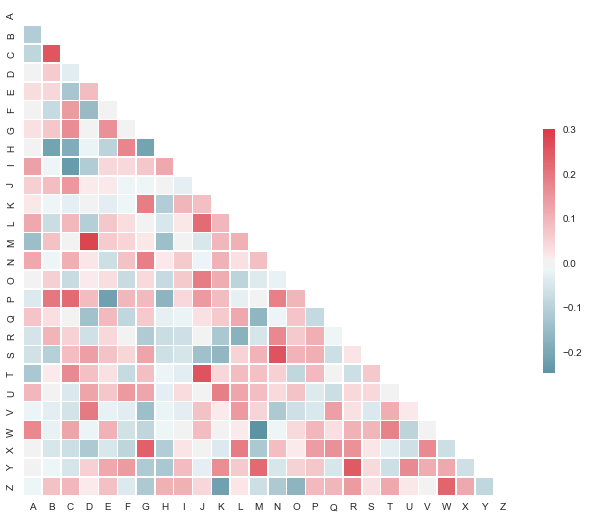

In [4]:
# TODO: At this point, we can do anything that can be done with a pandas dataframe. For example:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<h3 style="color:#9E9E9E">References</h3>

1. Trapnell, Cole, et al. "Differential gene and transcript expression analysis of RNA-seq experiments with TopHat and Cufflinks." Nature protocols 7.3 (2012): 562-578.
2. Trapnell, Cole, Lior Pachter, and Steven L. Salzberg. "TopHat: discovering splice junctions with RNA-Seq." Bioinformatics 25.9 (2009): 1105-1111.
3. Langmead, Ben, and Steven L. Salzberg. "Fast gapped-read alignment with Bowtie 2." Nature methods 9.4 (2012): 357-359.

<h3 style="color:#9E9E9E">Contact</h3>

Want to get in touch? You can [provide feedback](https://goo.gl/forms/2cOmuUrQ3n3CKpim1) regarding this or other documentation,
[reach out to us](https://goo.gl/forms/j8FWdNJqABAoJvcW2) regarding collaboration, or [request a new feature or analytical capability](https://goo.gl/forms/dQm3SDcoNZsV7AAd2). We're looking forward to hearing from you!

<div style="padding-top: 30px">
<p style="color:#9E9E9E; text-align:center">This notebook was prepared as part of the <a href="https://github.com/iqtk/iqtk">Inquiry Toolkit</a> project at the Joint BioEnergy Institute (JBEI). Learn more at https://www.jbei.org/.</p>
<p style="color:#9E9E9E; text-align:center">The Joint BioEnergy Institute is a program of the U.S. Department of Energy Office of Science.</p>
<p style="color:#9E9E9E; text-align:center">© Regents of the University of California, 2017. Licensed under a BSD-3 <a href="https://github.com/iqtk/iqtk/blob/master/LICENSE">license</a>.</p>
<img src="https://discover.iqtk.io/assets/logotype_blue_small.png" style="width:100px"></img>
</div>